# Analysis of time series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run plot.py

### Read data

N =  10000 L =  60


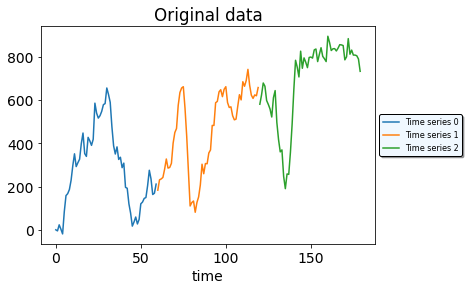

data:  10000
True


In [2]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

print('N = ', N, 'L = ', L)

Show_data(x,L,"Original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

# convert y to an (N x n_class) matrix

# Directly pass to one hot encoding avoiding the for cycle
y =tf.keras.utils.to_categorical(categ, n_class)

### Rescale data, split train/val.

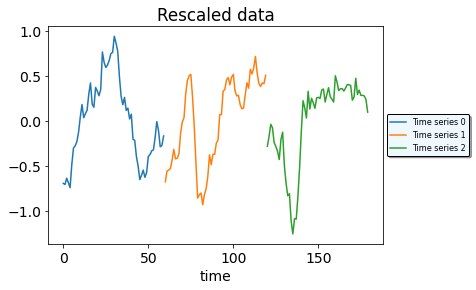

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [ ]:
# remove average value of each sample from its values
xm = x.mean(axis=1)
# subtract the mean avoiding the for cycle
x = (x.T - xm.T).T


# rescale 
x = x/400
# x = x/np.std(x) # if axis is not specified it computes the standard deviation of the flattened array
    
Show_data(x,L,"Rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

Remove the tilt in the series. It can be useful as it is not related to our problem.

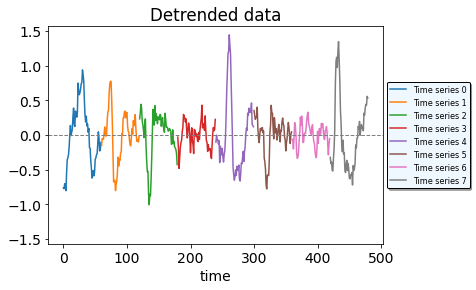

In [ ]:
from scipy import signal
x_detrended = signal.detrend(x)

Show_data(x_detrended, L, 'Detrended data', 8, show=False)
ax = plt.gca()
ax.axhline(0, c="gray", linestyle='--', linewidth=1)
low, high = plt.ylim()
bound = bound = max(abs(low), abs(high))
ax.set_ylim(-bound, bound)

plt.show()

## Convolutional NN

In [ ]:
# ... LESSON ...
# reproducibility

import tensorflow.random as tf_r
tf_r.set_seed(12345)

np.random.seed(12345)

from keras import regularizers, initializers
reg = regularizers.l2(0.02)# ridge with lambda
#reg regularizerts.l1(0.1)
ini = keras.initializers.RandomNormal(mean=0., stddev=.05, seed=None)

NCONV = 1
NF = 5 # number of filters

model = Sequential()
if NCONV == 1:
    #-----2----
    model.add(Conv1D(filters=NF, kernel_size=11, kernel_initializer=ini,
                     kernel_regularizer=reg, activation = 'relu', 
                     input_shape=input_shape))
    
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7,
                     activation='relu'))
    model.add(Flatten())# To be sent to a normal neural network layer
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    



model.add(Dense(n_class, activation='softmax'))
print("-----Model ", NCONV, "------")
model.summary()

#optimizers
#.RMSprop()
#.Nadam()
opt= tf.keras.optimizers.Adam()

#compile the model
#categorical cross entropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt, metrics=['accuracy'])

-----Model  1 ------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 5)             60        
                                                                 
 average_pooling1d (AverageP  (None, 10, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 12)                252       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                   

In [ ]:
model.layers

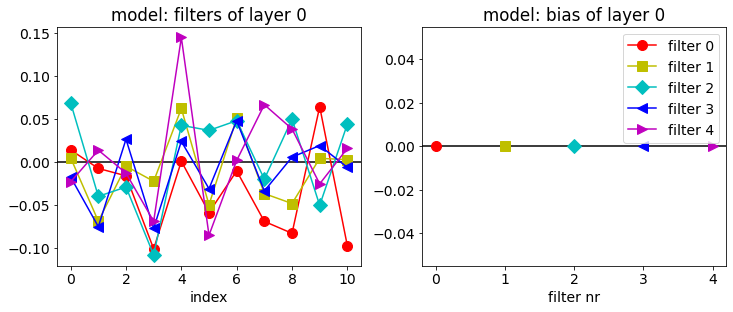

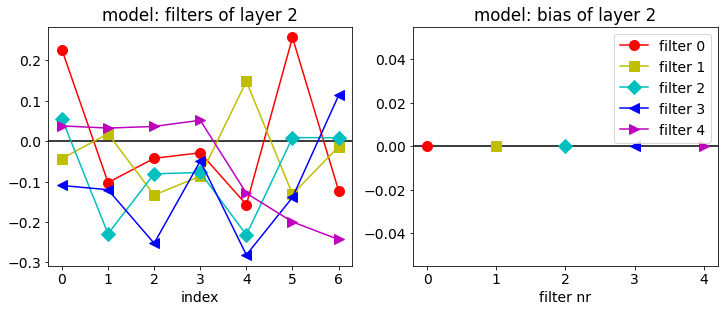

In [ ]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]#weights
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]#bias
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

In [ ]:
# ...LESSON ...

BATCH_SIZE = 250
EPOCHS = 100


print('-------Model',NCONV, '--------\nFITTING,......')
fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val,y_val),
                verbose=2, shuffle=True)
    

-------Model 1 --------
FITTING,......
Epoch 1/100
32/32 - 1s - loss: 1.0994 - accuracy: 0.3483 - val_loss: 1.0951 - val_accuracy: 0.3835 - 1s/epoch - 37ms/step
Epoch 2/100
32/32 - 0s - loss: 1.0874 - accuracy: 0.4009 - val_loss: 1.0735 - val_accuracy: 0.4205 - 184ms/epoch - 6ms/step
Epoch 3/100
32/32 - 0s - loss: 1.0498 - accuracy: 0.4793 - val_loss: 1.0219 - val_accuracy: 0.5340 - 205ms/epoch - 6ms/step
Epoch 4/100
32/32 - 0s - loss: 0.9823 - accuracy: 0.5732 - val_loss: 0.9340 - val_accuracy: 0.6550 - 189ms/epoch - 6ms/step
Epoch 5/100
32/32 - 0s - loss: 0.9012 - accuracy: 0.6339 - val_loss: 0.8322 - val_accuracy: 0.7080 - 204ms/epoch - 6ms/step
Epoch 6/100
32/32 - 0s - loss: 0.7973 - accuracy: 0.6976 - val_loss: 0.7260 - val_accuracy: 0.7650 - 185ms/epoch - 6ms/step
Epoch 7/100
32/32 - 0s - loss: 0.7027 - accuracy: 0.7449 - val_loss: 0.6204 - val_accuracy: 0.8070 - 195ms/epoch - 6ms/step
Epoch 8/100
32/32 - 0s - loss: 0.6108 - accuracy: 0.7793 - val_loss: 0.5254 - val_accuracy: 0.8

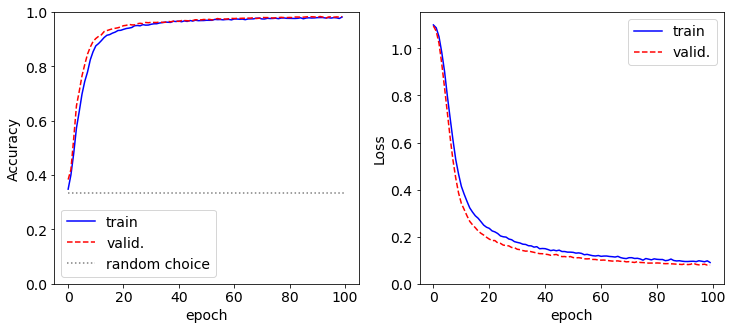

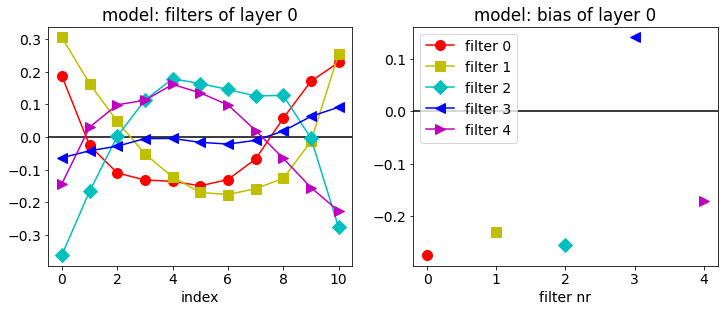

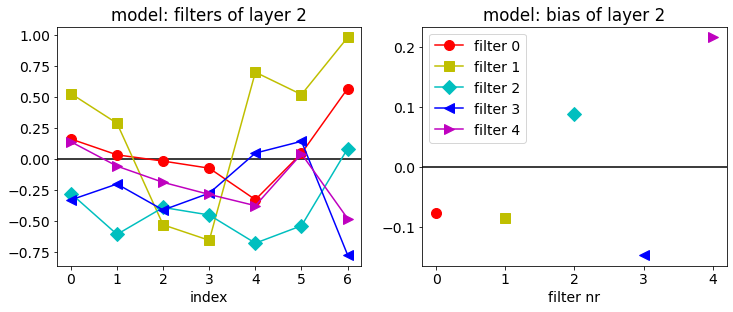

In [ ]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

In [ ]:
# ...LESSON ...
reg2 = regularizers.l2(2.0)
model2 = keras.models.clone_model(model)

model2.layers[0].kernel_regularizer= reg2
model2.layers[2].kernel_regularizer = reg2
model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

BATCH_SIZE2 = 250
EPOCHS2 = 100


fit2 = model2.fit(x_train,y_train, batch_size=BATCH_SIZE2, epochs=EPOCHS2,
                  validation_data=(x_val,y_val),
                  verbose=2, shuffle=True)

Epoch 1/100
32/32 - 1s - loss: 1.0324 - accuracy: 0.4456 - val_loss: 0.8909 - val_accuracy: 0.6490 - 717ms/epoch - 22ms/step
Epoch 2/100
32/32 - 0s - loss: 0.7768 - accuracy: 0.7076 - val_loss: 0.6097 - val_accuracy: 0.8200 - 173ms/epoch - 5ms/step
Epoch 3/100
32/32 - 0s - loss: 0.5398 - accuracy: 0.8169 - val_loss: 0.3964 - val_accuracy: 0.8820 - 202ms/epoch - 6ms/step
Epoch 4/100
32/32 - 0s - loss: 0.4030 - accuracy: 0.8731 - val_loss: 0.3121 - val_accuracy: 0.9135 - 193ms/epoch - 6ms/step
Epoch 5/100
32/32 - 0s - loss: 0.3336 - accuracy: 0.9014 - val_loss: 0.2675 - val_accuracy: 0.9240 - 203ms/epoch - 6ms/step
Epoch 6/100
32/32 - 0s - loss: 0.2982 - accuracy: 0.9125 - val_loss: 0.2359 - val_accuracy: 0.9290 - 195ms/epoch - 6ms/step
Epoch 7/100
32/32 - 0s - loss: 0.2680 - accuracy: 0.9234 - val_loss: 0.2198 - val_accuracy: 0.9400 - 191ms/epoch - 6ms/step
Epoch 8/100
32/32 - 0s - loss: 0.2548 - accuracy: 0.9270 - val_loss: 0.2036 - val_accuracy: 0.9450 - 196ms/epoch - 6ms/step
Epoch 9

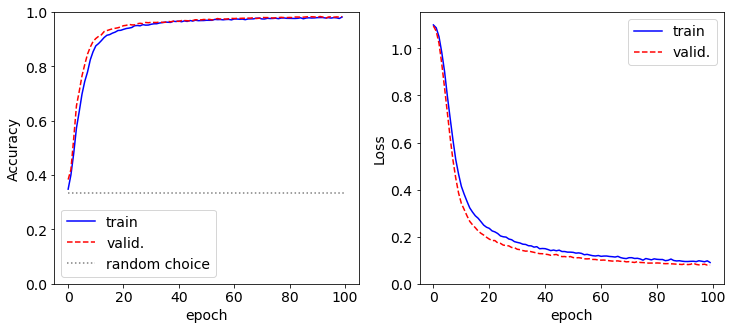

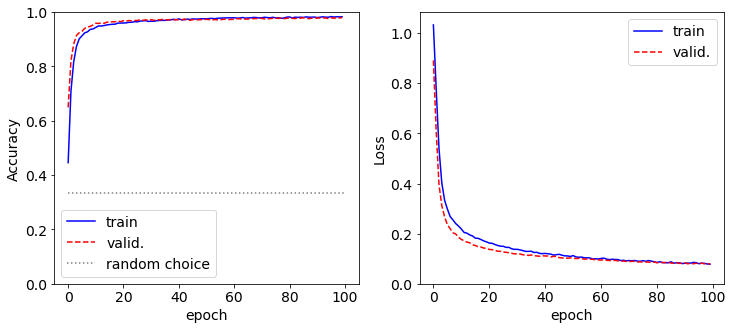

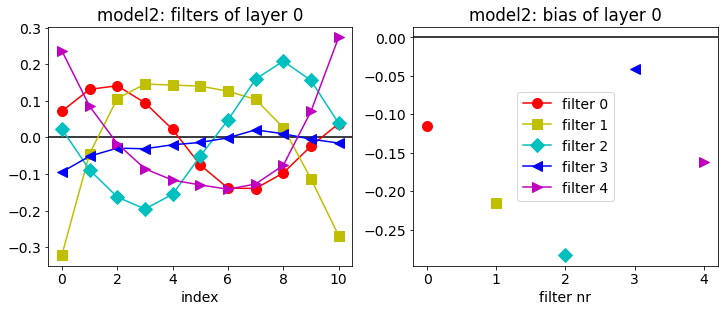

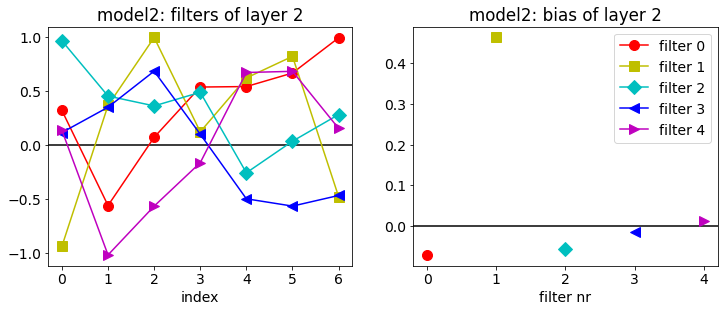

In [ ]:
Show_history(fit)
Show_history(fit2)
Show_weights(model2,0,label="model2")
Show_weights(model2,2,label="model2")

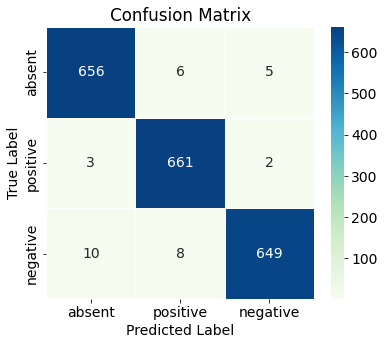

In [ ]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)

#print(classification_report(max_y_val, max_y_pred_val))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c8e8699-579b-4f24-9413-a98afebf04a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>